In [ ]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dotenv
import torch.nn.functional as F

dotenv.load_dotenv()


def gather_run_histories(columns, rows, lines, filters, runs, y_axis):
    unique_columns, unique_rows, unique_lines = set(), set(), set()
    for run in runs:
        continue_next_run = [False for _ in range(len(filters))]
        for i, filter_dict in enumerate(filters):
            if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
                continue_next_run[i] = True
        if np.array(continue_next_run).all():
            continue

        unique_columns.add(run.config[columns])
        unique_rows.add(run.config[rows])
        unique_lines.add(run.config[lines])

    unique_columns = sorted(list(unique_columns))
    unique_rows = sorted(list(unique_rows))
    unique_lines = sorted(list(unique_lines))
    print(unique_columns, unique_rows, unique_lines)

    series_dict = {}

    for run in runs:
        continue_next_run = [False for _ in range(len(filters))]
        for i, filter_dict in enumerate(filters):
            if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
                continue_next_run[i] = True
        if np.array(continue_next_run).all():
            continue

        row_label = run.config[rows]
        column_label = run.config[columns]

        i = unique_rows.index(row_label)
        j = unique_columns.index(column_label)

        historys = run.history(keys=y_axis).set_index("_step")
        mean_series = historys.mean(axis=1)
        mean_series.name = run.config["seed"]
        if (i, j) not in series_dict:
            series_dict[(i, j)] = {}

        if run.config[lines] not in series_dict[(i, j)]:
            series_dict[(i, j)][run.config[lines]] = mean_series.to_frame()
        else:
            series_dict[(i, j)][run.config[lines]][mean_series.name] = mean_series

    y_lines = [f"{s.split('/')[0]} {s.split('/')[1].upper()}" for s in y_axis]
    title = f"Comparing {str.join(', ', y_lines)} over {columns} and {rows} for different {lines}"

    return unique_columns, unique_rows, series_dict, title


def plot_metrics_in_grid(unique_columns, unique_rows, series_dict, title, label_prefix, x_limits):
    plot_size = 7
    fig, axes = plt.subplots(len(unique_rows), len(unique_columns), figsize=(plot_size * len(unique_columns), plot_size * len(unique_rows)))
    for (i, j), graph_data in series_dict.items():
        row_label, column_label = unique_rows[i], unique_columns[j]
        for line_label, df_series in graph_data.items():
            df_series.ffill(inplace=True)
            mean_series = df_series.mean(axis=1)
            std_series = df_series.std(axis=1)
            axes[i, j].fill_between(mean_series.index, mean_series - std_series, mean_series + std_series, alpha=0.2)
            axes[i, j].plot(mean_series, label=f"{label_prefix}{line_label}")

        if j == 0:
            axes[i, j].set_ylabel(row_label)
        if i == 0:
            axes[i, j].set_title(column_label)
        axes[i, j].set_ylim(0)
        axes[i, j].set_xlim(*x_limits)
        axes[i, j].legend()
        # axes[i, j].set_yscale('log')

    fig.suptitle(title)
    plt.tight_layout()
    fig.savefig(f"../out/plots/baselines/grid_{title}.pdf")
    plt.show()


def plot_metrics(unique_columns, unique_rows, series_dict, title, label_prefix, x_limits):
    # Plot the metrics in a single plot and average over seeds, columns and rows, just like the grid plot
    # Average the different seeds, columns and rows such that a pingle plot with multiple lines of just line_label is created
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    line_dict = {}
    for (i, j), graph_data in series_dict.items():
        row_label, column_label = unique_rows[i], unique_columns[j]
        for line_label, df_series in graph_data.items():
            if line_label not in line_dict:
                line_dict[line_label] = [df_series]
            else:
                line_dict[line_label].append(df_series)

    for line_label, df_series_list in line_dict.items():
        df_series = pd.concat(df_series_list, axis=1, join="inner")
        # df_series.ffill(inplace=True)
        mean_series = df_series.mean(axis=1)
        std_series = df_series.std(axis=1)
        ax.fill_between(mean_series.index, mean_series - std_series, mean_series + std_series, alpha=0.2)
        ax.plot(mean_series, label=f"{label_prefix}{line_label}")

    ax.set_xlim(*x_limits)
    ax.legend()
    fig.suptitle(title)
    plt.tight_layout()
    fig.savefig(f"./out/plots/baselines/all_{title}.pdf")
    plt.show()


## CREATE TABLES


def gather_final_metrics_by_parameters(columns, rows, metrics, variable, filters, runs, variables_other_sorted=None, specific_seed=None):
    history_dict = {}
    if isinstance(runs, list):
        runs = [run for run_list in runs for run in run_list]

    runs_found = 0
    for run in runs:
        if specific_seed is not None and run.config["seed"] != specific_seed:
            continue

        continue_next_run = [False for _ in range(len(filters))]
        for i, filter_dict in enumerate(filters):
            if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
                continue_next_run[i] = True
        if np.array(continue_next_run).all():
            continue

        run_column = str(run.config[columns]).replace("JitGRU_Predictor", "GRU_Predictor").replace("_Predictor", "")
        run_row = str(run.config[rows]).replace("JitGRU_Predictor", "GRU_Predictor").replace("_Predictor", "")
        run_variable = str(run.config[variable]).replace("JitGRU_Predictor", "GRU_Predictor").replace("_Predictor", "")
        run_metric = [run.summary[metric] for metric in metrics]
        # run_metric = { metric: run.summary[metric] for metric in metrics}
        run_seed = run.config["seed"]

        if (run_column, run_row, run_variable) not in history_dict:
            history_dict[(run_column, run_row, run_variable)] = [run_metric]
        else:
            history_dict[(run_column, run_row, run_variable)].append(run_metric)
        runs_found += 1

    print(f"Found {runs_found} runs with metrics: {history_dict}")

    unique_columns = sorted(list(set([column for column, _, _ in history_dict.keys()])))
    unique_rows = sorted(list(set([row for _, row, _ in history_dict.keys()])))
    unique_variables = sorted(list(set([variable for _, _, variable in history_dict.keys()])))
    if variables_other_sorted is not None:
        unique_variables = variables_other_sorted

    print(unique_columns, unique_rows, unique_variables)

    # Create a table with the average metrics for each variable
    table = np.zeros((len(unique_columns), len(unique_rows), len(unique_variables), len(metrics) * 2))
    for j, row in enumerate(unique_rows):
        for i, column in enumerate(unique_columns):
            for k, variable in enumerate(unique_variables):
                if (column, row, variable) in history_dict:
                    table[i, j, k, 0:2] = np.mean(history_dict[(column, row, variable)], axis=0)
                    if len(history_dict[(column, row, variable)]) > 1:
                        table[i, j, k, 2:4] = np.std(history_dict[(column, row, variable)], axis=0)
                    else:
                        table[i, j, k, 2:4] = np.ones(2) * -1  # If there is only one seed, the std is -1 to indicate that there is no std
                else:
                    table[i, j, k, :] = np.nan
    return table, unique_columns, unique_rows, unique_variables


def print_latex_table_input_target(table, unique_columns, unique_rows, unique_variables, variable_name=""):
    print("\\begin{table*}[]")
    print("\\centering")
    print("\\resizebox{\linewidth}{!}{")
    print("\\begin{tabular}{l|l" + "|cc" * len(unique_columns) + "}")
    print("\\toprule")
    print(
        "      & Dataset                 & \\multicolumn{2}{c}{Electricity 370} & \\multicolumn{2}{c}{KDDCup} & \\multicolumn{2}{c}{London Smartmeter} & \\multicolumn{2}{c}{TNO Electricity} \\\\"
    )
    dataset_headers = " & ".join([f"\\multicolumn{{2}}{{c}}{{{col}}}" for col in unique_columns])
    print(f"      & REPLACE                 & {dataset_headers} \\\\")
    print("\\midrule")

    # print(f"Model & {variable_name} & Input            & Target           & Input       & Target       & Input             & Target            & Input            & Target           \\\\")
    print(f"Model & {variable_name} & {'           & '.join(['Input & Target'] * len(unique_columns))} \\\\")
    print("\\midrule")

    def add_bold_if_min(number_value, string, minimum):
        if number_value == minimum:
            return "\\textbf{" + str(string) + "}"
        return str(string)

    def format_mean_std_value(value, std):
        if value < 1e-3:
            if std > 0:
                return f"{value:.1E}$\pm${std:.1E}".replace("E", "e")
            return f"{value:.1E}".replace("E", "e")
        if std > 0:
            return f"{value:.3f}$\pm${std:.3f}"
        return f"{value:.3f}"

    for j, row in enumerate(unique_rows):
        for k, variable in enumerate(unique_variables):
            if k == 0:
                row_values = [f"{row.replace('_Predictor', '')}\t& {variable}\t"]
            else:
                row_values = [f"\t& {variable}\t"]
            for i, column in enumerate(unique_columns):
                # Assuming last dimension is for mean values and we want the first element
                input_mean_value, target_mean_value = table[i, j, k, 0], table[i, j, k, 1]
                input_std_value, target_std_value = table[i, j, k, 2], table[i, j, k, 3]
                # If the input mean or target mean are the minimum value then it should be printed in bold with \textbf{}
                if not np.isnan(input_mean_value):
                    row_string_value = f""
                    row_string_value += add_bold_if_min(
                        input_mean_value, format_mean_std_value(input_mean_value, input_std_value), np.nanmin(table[i, j, :, 0])
                    )
                    row_string_value += " & "
                    row_string_value += add_bold_if_min(
                        target_mean_value, format_mean_std_value(target_mean_value, target_std_value), np.nanmin(table[i, j, :, 1])
                    )
                    row_values.append(row_string_value)
                else:
                    row_values.append("N/A & N/A")
            print(" & ".join(row_values) + " \\\\")
        if j != len(unique_rows) - 1:
            print("\\midrule")

    print("\\bottomrule")
    print("\\end{tabular}}")
    print("\\caption{}")
    print("\\end{table*}")


def print_latex_table_input_only(table, unique_columns, unique_rows, unique_variables, variable_name=""):
    header_row = " & " + " & ".join(unique_columns) + " \\\\ \\hline"

    print("\\begin{table*}[]")
    print("\\centering")
    print("\\resizebox{\linewidth}{!}{")
    # Modify the column definitions in LaTeX from two columns per dataset to one
    print("\\begin{tabular}{l|l" + "|c" * len(unique_columns) + "}")
    print("\\toprule")
    # Remove 'Target' from the column header
    # dataset_headers = " & ".join([f"\\multicolumn{{1}}{{c}}{{{col}}}" for col in unique_columns])
    # print(f"      & Dataset                 & {dataset_headers} \\\\")
    print(
        "      & Dataset                 & \\multicolumn{1}{c}{Electricity 370} & \\multicolumn{1}{c}{KDDCup} & \\multicolumn{1}{c}{London Smartmeter} & \\multicolumn{1}{c}{TNO Electricity} \\\\"
    )

    print("\\midrule")

    print(f"Model & {variable_name} & " + " & ".join(["Input" for _ in unique_columns]) + " \\\\")
    print("\\midrule")

    for j, row in enumerate(unique_rows):
        for k, variable in enumerate(unique_variables):
            if k == 0:
                row_values = [f"{row}\t& {variable}\t"]
            else:
                row_values = [f"\t& {variable}\t"]
            for i, column in enumerate(unique_columns):
                input_mean_value, input_std_value = table[i, j, k, 0], table[i, j, k, 2]
                if not np.isnan(input_mean_value):
                    row_string_value = f""
                    if input_mean_value == np.nanmin(table[i, j, :, 0]):
                        row_string_value += "\\textbf{"
                    if input_mean_value < 1e-3:
                        row_string_value += f"{input_mean_value:.1E}$\pm${input_std_value:.1E}".replace("E", "e")
                    else:
                        row_string_value += f"{input_mean_value:.3f}$\pm${input_std_value:.3f}"
                    if input_mean_value == np.nanmin(table[i, j, :, 0]):
                        row_string_value += "}"
                    row_values.append(row_string_value)
                else:
                    row_values.append("N/A")
            print(" & ".join(row_values) + " \\\\")
        if j != len(unique_rows) - 1:
            print("\\midrule")

    print("\\bottomrule")
    print("\\end{tabular}}")
    print("\\caption{}")
    print("\\end{table*}")


# PLOT RECONSTRUCTIONS

from matplotlib.gridspec import GridSpec
from matplotlib.transforms import Bbox
import wandb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import torch
import dotenv
import json
import os


def gather_run_reconstructions(dataset_seed, columns, rows, variables, filters, runs, replace_dict={}):
    def dataframe_keys_and_should_skip_run(run):
        if run.config["dataset"] not in dataset_seed or run.config["seed"] != dataset_seed[run.config["dataset"]]:
            return [], True

        dataframe_keys = []
        for key in run.summary.keys():
            if "dataframe" in key:
                dataframe_keys.append(key)
        if len(dataframe_keys) == 0:
            return [], True

        continue_next_run = [False for _ in range(len(filters))]
        for i, filter_dict in enumerate(filters):
            if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
                continue_next_run[i] = True
        if np.array(continue_next_run).all():
            return [], True
        return dataframe_keys, False

    def replace_predictor_name(runs_config, name):
        run_config_value = runs_config[name]
        for key, value in replace_dict.items():
            if isinstance(run_config_value, str):
                run_config_value = run_config_value.replace(key, value)
        if name == "dataset":
            return f"{run_config_value} ({dataset_seed[runs_config[name]]})"
        if name == "model":
            return run_config_value.replace("JitGRU_Predictor", "GRU_Predictor").replace("_Predictor", "")
        return run_config_value

    reconstructed_data_dict = {}
    if isinstance(runs, list):
        runs = [run for run_list in runs for run in run_list]

    for run in runs:
        dataframe_keys, should_skip_run = dataframe_keys_and_should_skip_run(run)
        if should_skip_run:
            continue

        run_column = replace_predictor_name(run.config, columns)
        run_row = replace_predictor_name(run.config, rows)
        run_variable = replace_predictor_name(run.config, variables)

        dataframe_info = run.summary[dataframe_keys[0]]
        file = run.file(dataframe_info["path"])
        if not os.path.exists(file.name):
            file.download(replace=True)
        with open(file.name, "r") as f:
            data = json.load(f)
        reconstructed_data = pd.DataFrame(data=data["data"], columns=data["columns"])
        if (run_column, run_row, run_variable) not in reconstructed_data_dict:
            reconstructed_data_dict[(run_column, run_row, run_variable)] = reconstructed_data

    print(reconstructed_data_dict.keys())

    unique_columns = sorted(list(set([column for column, _, _ in reconstructed_data_dict.keys()])))
    unique_rows = sorted(list(set([row for _, row, _ in reconstructed_data_dict.keys()])))
    unique_variables = sorted(list(set([variable for _, _, variable in reconstructed_data_dict.keys()])))

    return reconstructed_data_dict, unique_columns, unique_rows, unique_variables


def plot_single_batch_reconstructions_in_grid(
    series_dict,
    unique_columns,
    unique_rows,
    unique_variables,
    extra_title="",
    legend_loc="upper left",
    column_offset=0.0,
    plot_size_width=2,
    plot_size_height=0.33,
    legend_font_size=7,
):
    fig = plt.figure(figsize=(plot_size_width * len(unique_columns), plot_size_height * len(unique_rows) * len(unique_variables)))
    subfigs = fig.subfigures(len(unique_rows), len(unique_columns))
    if len(unique_rows) == 1 and len(unique_columns) == 1:
        subfigs = np.array([[subfigs]])
    elif len(unique_rows) == 1:
        subfigs = np.array([subfigs])
    elif len(unique_columns) == 1:
        subfigs = np.array([subfigs]).T

    colors = plt.cm.tab10.colors

    for i, row_label in enumerate(unique_rows):
        for j, column_label in enumerate(unique_columns):
            subfig = subfigs[i, j]
            subfig.subplots_adjust(wspace=0, hspace=0, left=0.05, right=0.99, top=0.9, bottom=0.05)
            axes_1 = subfig.subplots(len(unique_variables), 1, sharex=True, sharey=True)
            if len(unique_variables) == 1:
                axes_1 = [axes_1]
            for k, variable in enumerate(unique_variables):
                if (column_label, row_label, variable) in series_dict:
                    reconstructed_data = series_dict[(column_label, row_label, variable)]
                    n_batches = len(reconstructed_data.columns) // 4
                    for b in range(n_batches):
                        df_plot = reconstructed_data[[f"batch_inputs_{b}_0", f"batch_targets_{b}"]]
                        batch_colors = [colors[(2 * b) % 10], colors[(2 * b + 2) % 10]]
                        df_plot.plot(ax=axes_1[k], legend=False, color=batch_colors)

                    for b in range(n_batches):
                        df_plot = reconstructed_data[[f"dummy_inputs_{b}_0", f"dummy_targets_{b}"]]
                        dummy_colors = [colors[(2 * b + 1) % 10], colors[(2 * b + 3) % 10]]
                        df_plot.plot(ax=axes_1[k], legend=False, style=["--", "--"], color=dummy_colors)

                    # reconstructed_data.plot(ax=axes_1[k], legend=False)
                    dummy_handle = mlines.Line2D([], [], color="none", label=variable)
                    axes_1[k].legend(handles=[dummy_handle], loc=legend_loc, handlelength=0, handletextpad=0, fancybox=True, fontsize=legend_font_size)

                axes_1[k].set_ylim(-0.1, 1.1)
                axes_1[k].set_yticks([])
                axes_1[k].set_xticks([])

            if i == 0:
                subfig.text(0.5, 1.0 + column_offset, column_label, ha="center", va="top")
            if j == 0:
                subfig.text(0.0, 0.5, row_label, ha="left", va="center", fontsize=8, rotation=90)

    fig.savefig(f"./out/plots/reconstructions/grid_reconstructions_{extra_title}.pdf")
    plt.show()


from src.attack_time_series_utils import SMAPELoss


def get_batch_sample_mapping(original_data, dummy_data):
    batch_size = original_data.shape[0]
    sample_mapping = np.arange(0, batch_size)
    for i in range(batch_size):
        smallest_loss = float("inf")
        for j in range(batch_size):
            loss = F.l1_loss(original_data[i], dummy_data[j]).detach().item()  # instead of MSE because L1 is less sensitive to outliers
            if loss < smallest_loss:
                smallest_loss = loss
                sample_mapping[i] = j
    # Check if sample_mapping contains duplicates; if so, reset it
    if len(np.unique(sample_mapping)) != batch_size:
        sample_mapping = np.arange(0, batch_size)
    return sample_mapping


def get_batch_sample_mapping_from_dataframe(reconstructed_data, batch_size):
    original_inputs = torch.tensor(reconstructed_data[[f"batch_inputs_{i}_0" for i in range(batch_size)]].dropna().values.T).unsqueeze(-1)
    dummy_inputs = torch.tensor(reconstructed_data[[f"dummy_inputs_{i}_0" for i in range(batch_size)]].dropna().values.T).unsqueeze(-1)
    original_targets = torch.tensor(reconstructed_data[[f"batch_targets_{i}" for i in range(batch_size)]].dropna().values.T).unsqueeze(-1)
    dummy_targets = torch.tensor(reconstructed_data[[f"dummy_targets_{i}" for i in range(batch_size)]].dropna().values.T).unsqueeze(-1)
    # print(original_inputs.shape, dummy_inputs.shape, original_targets.shape, dummy_targets.shape)

    standard_mapping = np.arange(0, batch_size)
    input_sample_mapping = get_batch_sample_mapping(original_inputs, dummy_inputs)
    target_sample_mapping = get_batch_sample_mapping(original_targets, dummy_targets)

    sample_mapping = np.arange(0, batch_size)
    if not (standard_mapping == input_sample_mapping).all():
        sample_mapping = input_sample_mapping
    if (standard_mapping == input_sample_mapping).all() and not (standard_mapping == target_sample_mapping).all():
        sample_mapping = target_sample_mapping
    if not (standard_mapping == input_sample_mapping).all() and not (standard_mapping == target_sample_mapping).all():
        if not (input_sample_mapping == target_sample_mapping).all():
            raise ValueError("Input and target sample mappings are not equal while being different from the standard mapping.")
    return sample_mapping, original_inputs, dummy_inputs, original_targets, dummy_targets


def gather_final_metrics_from_reconstructions_by_parameters(columns, rows, metric, variable, filters, runs, variables_other_sorted=None):
    history_dict = {}
    if isinstance(runs, list):
        runs = [run for run_list in runs for run in run_list]

    runs_found = 0
    for run in runs:
        dataframe_keys = []
        for key in run.summary.keys():
            if "dataframe" in key:
                dataframe_keys.append(key)
        if len(dataframe_keys) == 0:
            continue

        continue_next_run = [False for _ in range(len(filters))]
        for i, filter_dict in enumerate(filters):
            if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
                continue_next_run[i] = True
        if np.array(continue_next_run).all():
            continue

        run_column = str(run.config[columns]).replace("JitGRU_Predictor", "GRU_Predictor").replace("_Predictor", "")
        run_row = str(run.config[rows]).replace("JitGRU_Predictor", "GRU_Predictor").replace("_Predictor", "")
        run_variable = str(run.config[variable]).replace("JitGRU_Predictor", "GRU_Predictor").replace("_Predictor", "")

        dataframe_info = run.summary[dataframe_keys[0]]
        file = run.file(dataframe_info["path"])
        if not os.path.exists(file.name):
            file.download(replace=True)
        with open(file.name, "r") as f:
            data = json.load(f)
        reconstructed_data = pd.DataFrame(data=data["data"], columns=data["columns"])

        sample_mapping, original_inputs, dummy_inputs, original_targets, dummy_targets = get_batch_sample_mapping_from_dataframe(
            reconstructed_data, run.config["batch_size"]
        )

        # Calculate the metrics
        run_metric = [metric(dummy_inputs[sample_mapping], original_inputs).item(), metric(dummy_targets[sample_mapping], original_targets).item()]

        if (run_column, run_row, run_variable) not in history_dict:
            history_dict[(run_column, run_row, run_variable)] = [run_metric]
        else:
            history_dict[(run_column, run_row, run_variable)].append(run_metric)
        runs_found += 1

    print(f"Found {runs_found} runs with reconstructions")
    unique_columns = sorted(list(set([column for column, _, _ in history_dict.keys()])))
    unique_rows = sorted(list(set([row for _, row, _ in history_dict.keys()])))
    unique_variables = sorted(list(set([variable for _, _, variable in history_dict.keys()])))
    if variables_other_sorted is not None:
        unique_variables = variables_other_sorted

    print(unique_columns, unique_rows, unique_variables)

    # Create a table with the average metrics for each variable
    table = np.zeros((len(unique_columns), len(unique_rows), len(unique_variables), 4))
    for j, row in enumerate(unique_rows):
        for i, column in enumerate(unique_columns):
            for k, variable in enumerate(unique_variables):
                if (column, row, variable) in history_dict:
                    table[i, j, k, 0:2] = np.mean(history_dict[(column, row, variable)], axis=0)
                    if len(history_dict[(column, row, variable)]) > 1:
                        table[i, j, k, 2:4] = np.std(history_dict[(column, row, variable)], axis=0)
                    else:
                        table[i, j, k, 2:4] = -1 * np.ones(2)  # If there is only one seed, the std is -1 to indicate that there is no std
                else:
                    table[i, j, k, :] = np.nan
    return table, unique_columns, unique_rows, unique_variables


def plot_multi_batch_reconstructions_in_grid(
    series_dict,
    unique_columns,
    unique_rows,
    unique_batch_sizes,
    extra_title="",
    legend_loc="upper left",
    column_offset=0.0,
    plot_size_width=2,
    plot_size_height=0.33,
    legend_font_size=7,
):
    fig = plt.figure(figsize=(plot_size_width * len(unique_columns), plot_size_height * len(unique_rows) * sum(unique_batch_sizes)))
    subfigs = fig.subfigures(len(unique_rows), len(unique_columns))
    if len(unique_rows) == 1 and len(unique_columns) == 1:
        subfigs = np.array([[subfigs]])
    elif len(unique_rows) == 1:
        subfigs = np.array([subfigs])
    elif len(unique_columns) == 1:
        subfigs = np.array([subfigs]).T

    for i, row_label in enumerate(unique_rows):
        for j, column_label in enumerate(unique_columns):
            subfig = subfigs[i, j]

            batch_size = [bs for bs in unique_batch_sizes if (column_label, row_label, bs) in series_dict][0]

            subfig.subplots_adjust(wspace=0, hspace=0, left=0.05, right=0.99, top=0.9, bottom=0.05)
            axes = subfig.subplots(max(unique_batch_sizes), 1, sharex=True, sharey=True)

            if (column_label, row_label, batch_size) in series_dict:
                reconstructed_data = series_dict[(column_label, row_label, batch_size)]
                sample_mapping, batch_inputs, dummy_inputs, batch_targets, dummy_targets = get_batch_sample_mapping_from_dataframe(
                    reconstructed_data, batch_size
                )
                original_x_axis = np.arange(0, batch_inputs.shape[1] + batch_targets.shape[1])
                for b, d in enumerate(sample_mapping):
                    ax = axes[b] if batch_size > 1 else axes
                    ax.plot(original_x_axis[: batch_inputs.shape[1]], batch_inputs[b, :].detach().cpu().numpy())
                    ax.plot(original_x_axis[: batch_inputs.shape[1]], dummy_inputs[d, :].detach().cpu().numpy())

                    ax.plot(original_x_axis[batch_inputs.shape[1] :], batch_targets[b, :].detach().cpu().numpy())
                    ax.plot(original_x_axis[batch_inputs.shape[1] :], dummy_targets[d, :].detach().cpu().numpy())

                    dummy_handle = mlines.Line2D([], [], color="none", label=f"Sample {b}")
                    ax.legend(handles=[dummy_handle], loc=legend_loc, handlelength=0, handletextpad=0, fancybox=True, fontsize=legend_font_size)
                    ax.set_ylim(-0.1, 1.1)
                    ax.set_yticks([])
                    ax.set_xticks([])

            if i == 0:
                subfig.text(0.5, 1.0 + column_offset, column_label, ha="center", va="top")
            if j == 0:
                subfig.text(0.0, 0.5, row_label, ha="left", va="center", fontsize=8, rotation=90)

    fig.savefig(f"./out/plots/reconstructions/grid_reconstructions_{extra_title}.pdf", bbox_inches="tight")
    plt.show()


api = wandb.Api()

# baselines_attacking_seq2seq_24-5-2024

Found 3707 runs
Found 36 runs with reconstructions
['electricity_370', 'tno_electricity'] ['JitSeq2Seq'] ['DLG-Adam', 'InvG_TV0', 'LTI', 'LTI_OOD']
\begin{table*}[]
\centering
\resizebox{\linewidth}{!}{
\begin{tabular}{l|l|cc|cc}
\toprule
      & Dataset                 & \multicolumn{2}{c}{Electricity 370} & \multicolumn{2}{c}{KDDCup} & \multicolumn{2}{c}{London Smartmeter} & \multicolumn{2}{c}{TNO Electricity} \\
      & REPLACE                 & \multicolumn{2}{c}{electricity_370} & \multicolumn{2}{c}{tno_electricity} \\
\midrule
Model & Attack Method & Input & Target           & Input & Target \\
\midrule
JitSeq2Seq	& DLG-Adam	 & 0.561$\pm$0.042 & \textbf{0.647$\pm$0.114} & 1.360$\pm$0.112 & 1.501$\pm$0.089 \\
	& InvG_TV0	 & 1.118$\pm$0.164 & 0.652$\pm$0.110 & 1.881$\pm$0.114 & 1.604$\pm$0.265 \\
	& LTI	 & \textbf{0.175$\pm$0.040} & 0.672$\pm$0.067 & \textbf{0.452$\pm$0.111} & \textbf{1.350$\pm$0.128} \\
	& LTI_OOD	 & 0.203$\pm$0.050 & 0.672$\pm$0.067 & 0.509$\pm$0.058 & \textbf{1.

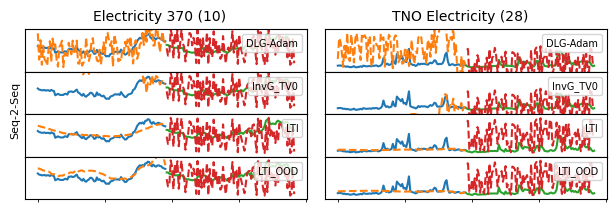

In [4]:
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-baselines-time-series")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'baselines_attacking_seq2seq_24-5-2024',
    },
    {
        'experiment_name': lambda x: x == 'baselines_attacking_seq2seq_24-5-2024',
        'attack_method': lambda x: 'LTI' in x,
        'validation_stride': lambda x: x == 1,
    }
]

# metric_table, unique_columns, unique_rows, unique_variables = gather_final_metrics_by_parameters(columns='dataset', rows='model', 
#                                                                                                          metrics=['inputs/smape/mean', 'targets/smape/mean'], 
#                                                                                                          variable='attack_method', filters=filters, runs=runs)
# print_latex_table_input_target(metric_table, unique_columns, unique_rows, unique_variables, variable_name='Attack Method')

metric_table, unique_columns, unique_rows, unique_variables = gather_final_metrics_from_reconstructions_by_parameters(columns='dataset', rows='model', 
                                                                                                         metric=SMAPELoss, 
                                                                                                         variable='attack_method', filters=filters, runs=runs)
print_latex_table_input_target(metric_table, unique_columns, unique_rows, unique_variables, variable_name='Attack Method')

dataset_seed_dict = {
    'electricity_370': 10,
    # 'kddcup': 10,
    # 'london_smartmeter': 28,
    'tno_electricity': 28,
}
replace_dict = {
    'JitSeq2Seq': 'Seq-2-Seq',
    'electricity_370': 'Electricity 370',
    'tno_electricity': 'TNO Electricity',
}
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='model', variables='attack_method', filters=filters, runs=runs, replace_dict=replace_dict)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='attacking_seq2seq_24-05-2024', legend_loc='upper right', plot_size_height=0.5, plot_size_width=3)

# baselines_invg_targets_regularization_23-5-2024

Found 3730 runs
Found 9 runs with metrics: {('0.001', '0.001', 'CNN'): [[0.061585020273923874, 0.10451456159353256]], ('0.01', '0.001', 'CNN'): [[0.4832692742347718, 0.01139343809336424]], ('0', '0.001', 'CNN'): [[0.022852908819913864, 0.17736874520778656]], ('0.001', '0.01', 'CNN'): [[0.06267835199832916, 0.10451558232307434]], ('0.01', '0.01', 'CNN'): [[0.48603755235672, 0.011404410004615784]], ('0', '0.01', 'CNN'): [[0.023196030408143997, 0.17735764384269714]], ('0.001', '0', 'CNN'): [[0.09872029721736908, 0.1047610342502594]], ('0.01', '0', 'CNN'): [[0.7535181045532227, 0.01132233440876007]], ('0', '0', 'CNN'): [[0.001749515882693231, 0.1777549684047699]]}
['0', '0.001', '0.01'] ['0', '0.001', '0.01'] ['CNN']
\begin{table*}[]
\centering
\resizebox{\linewidth}{!}{
\begin{tabular}{l|l|cc|cc|cc}
\toprule
      & Dataset                 & \multicolumn{2}{c}{Electricity 370} & \multicolumn{2}{c}{KDDCup} & \multicolumn{2}{c}{London Smartmeter} & \multicolumn{2}{c}{TNO Electricity} \\
   

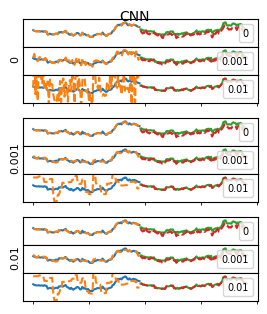

In [7]:
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-baselines-time-series")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'baselines_invg_targets_regularization_23-5-2024',
    }
]

metric_table, unique_columns, unique_rows, unique_variables = gather_final_metrics_by_parameters(columns='total_Variation_alpha_targets', rows='total_variation_alpha_inputs', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='model', filters=filters, runs=runs)
print_latex_table_input_target(metric_table, unique_columns, unique_rows, unique_variables, variable_name='TV')

dataset_seed_dict = {
    'electricity_370': 10,
    # 'kddcup': 10,
    # 'london_smartmeter': 28,
    # 'tno_electricity': 10,
}

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='model', rows='total_variation_alpha_inputs', variables='total_Variation_alpha_targets', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='invg_input_target_regularization', legend_loc='upper right', plot_size_height=0.33, plot_size_width=2.5)

# baselines_lti_ood_21-5-2024

Found 3675 runs
Found 4 runs with reconstructions
['electricity_370', 'tno_electricity'] ['GRU', 'TCN'] ['LTI']
\begin{table*}[]
\centering
\resizebox{\linewidth}{!}{
\begin{tabular}{l|l|c|c}
\toprule
      & Dataset                 & \multicolumn{1}{c}{Electricity 370} & \multicolumn{1}{c}{KDDCup} & \multicolumn{1}{c}{London Smartmeter} & \multicolumn{1}{c}{TNO Electricity} \\
\midrule
Model & attack_method & Input & Input \\
\midrule
GRU	& LTI	 & \textbf{0.141$\pm$-1.000} & \textbf{0.518$\pm$-1.000} \\
\midrule
TCN	& LTI	 & \textbf{0.127$\pm$-1.000} & \textbf{0.427$\pm$-1.000} \\
\bottomrule
\end{tabular}}
\caption{}
\end{table*}
dict_keys([('tno_electricity (10)', 'TCN', 10), ('electricity_370 (10)', 'TCN', 10), ('tno_electricity (10)', 'GRU', 10), ('electricity_370 (10)', 'GRU', 10)])


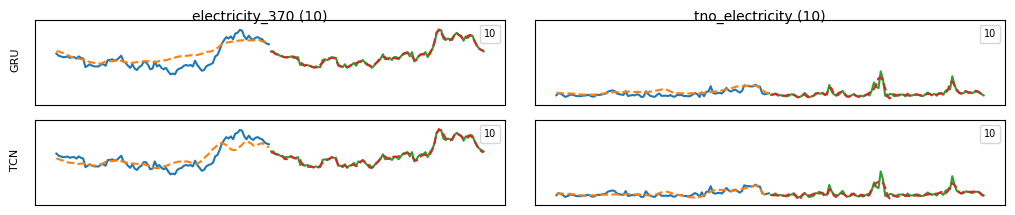

In [3]:
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-baselines-time-series")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'baselines_lti_ood_21-5-2024',
    }
]

metric_table, unique_columns, unique_rows, unique_variables = gather_final_metrics_from_reconstructions_by_parameters(columns='dataset', rows='model', 
                                                                                                         metric=SMAPELoss, 
                                                                                                         variable='attack_method', filters=filters, runs=runs)
print_latex_table_input_only(metric_table, unique_columns, unique_rows, unique_variables, variable_name='attack_method')

dataset_seed_dict = {
    'electricity_370': 10,
    # 'kddcup': 10,
    # 'london_smartmeter': 28,
    'tno_electricity': 10,
}

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='model', variables='seed', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='lti_seed_ood', legend_loc='upper right', plot_size_height=1, plot_size_width=5)

# DIA Total Variation Alpha

In [1]:
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-baselines-time-series")
print(f'Found {len(runs)} runs')

filters = [
    # {
    #     'experiment_name': lambda x: x == 'dlg-baselines_experiments-20-3-2024',
    # }
    {
        'experiment_name': lambda x: x == 'baselines_final_dia_tv_alpha_fix_scheduler_24-4-2024',
        # 'model': lambda x: 'FCN' in x or 'CNN' in x,
        # 'dataset': lambda x: 'electricity_370' in x or 'london_smartmeter' in x or 'tno_electricity' in x,
    }
]

metric_table, unique_columns, unique_rows, unique_variables = gather_final_metrics_by_parameters(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='total_variation_alpha', filters=filters, runs=runs)
print_latex_table_input_only(metric_table, unique_columns, unique_rows, unique_variables, variable_name='TV')

dataset_seed_dict = {
    'electricity_370': 10,
    # 'kddcup': 10,
    'london_smartmeter': 28,
    'tno_electricity': 28,
}

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='model', variables='total_variation_alpha', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='dia_total_variation_alpha', legend_loc='upper right')

NameError: name 'wandb' is not defined

# InvG TV experiment 17-05-2024

Found 3671 runs
Found 56 runs with metrics: {('london_smartmeter', 'FCN', '0'): [[7.374139386229217e-05, 1.4129998683929443], [8.951723430072889e-05, 1.1902916431427002]], ('electricity_370', 'FCN', '0'): [[4.367878318589646e-06, 0.10499478876590727], [3.5849395771947457e-06, 0.18445132672786713]], ('london_smartmeter', 'CNN', '0'): [[0.028352748602628708, 1.359215497970581], [0.01824864000082016, 0.7762831449508667]], ('electricity_370', 'CNN', '0'): [[0.00209609791636467, 0.07175706326961517], [0.001749515882693231, 0.1777549684047699]], ('london_smartmeter', 'FCN', '1e-07'): [[0.0015649510314688089, 1.4129937887191772], [0.0031377931591123343, 1.1902867555618286]], ('electricity_370', 'FCN', '1e-07'): [[3.474404729786329e-05, 0.10498644411563872], [6.727701111230999e-05, 0.18444184958934784]], ('london_smartmeter', 'CNN', '1e-07'): [[0.1119772344827652, 1.359210968017578], [0.16820180416107178, 0.7762645483016968]], ('electricity_370', 'CNN', '1e-07'): [[0.008437107317149639, 0.0717

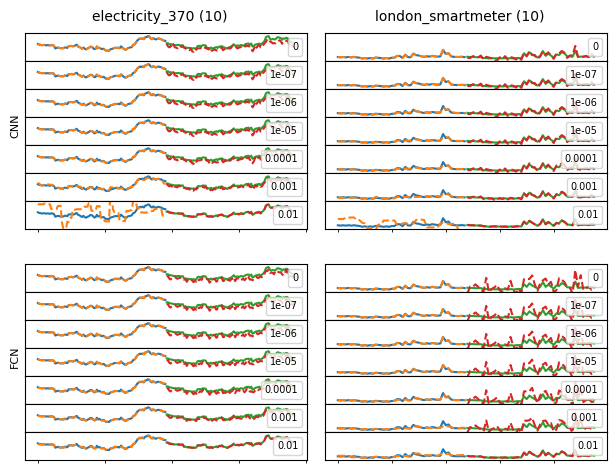

In [6]:
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-baselines-time-series")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'baselines_invg_total_variation_17-5-2024',
        # 'model': lambda x: 'FCN' in x or 'CNN' in x,
        # 'dataset': lambda x: 'electricity_370' in x or 'london_smartmeter' in x or 'tno_electricity' in x,
    }
]

metric_table, unique_columns, unique_rows, unique_variables = gather_final_metrics_by_parameters(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='total_variation_alpha', filters=filters, runs=runs)
print_latex_table_input_target(metric_table, unique_columns, unique_rows, unique_variables, variable_name='TV')

dataset_seed_dict = {
    'electricity_370': 10,
    # 'kddcup': 10,
    'london_smartmeter': 10,
    # 'tno_electricity': 28,
}

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='model', variables='total_variation_alpha', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='dia_total_variation_alpha', legend_loc='upper right', plot_size_width=3, plot_size_height=0.33)

In [7]:
# filters = [{
#     'experiment_name': lambda x: x == 'dlg-baselines_experiments-20-3-2024',
#     'attack_method': lambda x: x == 'InvG'
# }]
# u_columns, u_rows, series_dictionary, title = gather_run_histories(columns='dataset', rows='model', lines='total_variation_alpha', filters=filters, runs=runs, y_axis=['inputs/smape/mean', 'targets/smape/mean'])
# plot_metrics_in_grid(u_columns, u_rows, series_dictionary, title, label_prefix='TV: ', x_limits=(0, 5000))
# plot_metrics(u_columns, u_rows, series_dictionary, title, label_prefix='', x_limits=(0, 5000))

# u_columns, u_rows, series_dictionary, title = gather_run_histories(columns='dataset', rows='model', lines='total_variation_alpha', filters=filters, runs=runs, y_axis=['inputs/smape/mean'])
# plot_metrics_in_grid(u_columns, u_rows, series_dictionary, title, label_prefix='TV: ', x_limits=(0, 5000))
# plot_metrics(u_columns, u_rows, series_dictionary, title, label_prefix='', x_limits=(0, 5000))

# u_columns, u_rows, series_dictionary, title = gather_run_histories(columns='dataset', rows='model', lines='total_variation_alpha', filters=filters, runs=runs, y_axis=['targets/smape/mean'])
# plot_metrics_in_grid(u_columns, u_rows, series_dictionary, title, label_prefix='TV: ', x_limits=(0, 5000))
# plot_metrics(u_columns, u_rows, series_dictionary, title, label_prefix='', x_limits=(0, 5000))

# Comparison of baselines for datasets, model types & multiple seeds

In [8]:
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-baselines-time-series")
print(f'Found {len(runs)} runs')
filters = [
    {
        'experiment_name': lambda x: x == 'baselines_final_18-4-2024',
        'attack_method': lambda x: x != 'DIA',
    },
    {
        'experiment_name': lambda x: x == 'baselines_final_dia_lr_schedular_fix_23-4-2024', # num_attack_steps // 10
        'attack_method': lambda x: x == 'DIA',
    },

]
attack_methods_ordered_list = ['DLG-LBFGS', 'DLG-Adam', 'InvG_TV0', 'DIA', 'LTI']

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 28,
}

metric_table, unique_columns, unique_rows, unique_variables = gather_final_metrics_of_baselines(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='attack_method', filters=filters, runs=runs,
                                                                                                         variables_other_sorted=attack_methods_ordered_list)
print_latex_table_input_target(metric_table, unique_columns, unique_rows, unique_variables)

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='attack_method', rows='dataset', variables='model', filters=filters, runs=runs)
plot_reconstructions_in_grid(reconstruction_dict, attack_methods_ordered_list, u_rows, u_variables, dataset_seed_dict, extra_title='baselines_attack_method_x_model_x_dataset')

Found 3671 runs


NameError: name 'gather_final_metrics_of_baselines' is not defined

# Comparison of DIA with different learning rate schedular. Difference is both are using on plateau, but 1 checks //5 and the other //10

In [ ]:
runs = api.runs("capsar-meijer/tno-fl-baselines-time-series")
print(f'Found {len(runs)} runs')
filters = [
    {
        'experiment_name': lambda x: x == 'baselines_final_18-4-2024',
        'attack_method': lambda x: x == 'DIA'
    },
    {
        'experiment_name': lambda x: x == 'baselines_final_dia_lr_schedular_fix_23-4-2024',    
        'attack_method': lambda x: x == 'DIA'
    }
]

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 28,
}

metric_table, unique_columns, unique_rows, unique_variables = gather_final_metrics_of_baselines(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='experiment_name', filters=filters, runs=runs)
print_latex_table_input_target(metric_table, unique_columns, unique_rows, unique_variables)

Found 3392 runs
{('kddcup', 'GRU_Predictor', 'baselines_final_dia_lr_schedular_fix_23-4-2024'): {28: [1.8497356176376345, 1.297070860862732], 43: [1.7428526878356934, 1.6252403259277344], 10: [1.8817100524902344, 1.585038661956787]}, ('tno_electricity', 'GRU_Predictor', 'baselines_final_dia_lr_schedular_fix_23-4-2024'): {28: [1.6759202480316162, 1.4546566009521484], 43: [1.8189605474472048, 1.516055941581726], 10: [1.8042826652526855, 1.7185962200164795]}, ('london_smartmeter', 'GRU_Predictor', 'baselines_final_dia_lr_schedular_fix_23-4-2024'): {28: [1.7320650815963743, 1.5725297927856443], 43: [1.470250964164734, 1.7130203247070312], 10: [1.6120141744613647, 1.5780800580978394]}, ('electricity_370', 'GRU_Predictor', 'baselines_final_dia_lr_schedular_fix_23-4-2024'): {28: [1.063268542289734, 0.7418286204338074], 43: [1.5772531032562256, 0.713267982006073], 10: [1.3438657522201538, 0.4599038064479828]}, ('kddcup', 'TCN_Predictor', 'baselines_final_dia_lr_schedular_fix_23-4-2024'): {28: 

# Show difference in sMAPE of learning rate for DLG-Adam.


In [ ]:
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-baselines-time-series")
print(f'Found {len(runs)} runs')
filters = [
    {
        'experiment_name': lambda x: x == 'baselines_final_18-4-2024',
        'attack_method': lambda x: x == 'DLG-Adam',
    },
    {
        'experiment_name': lambda x: x == 'baseline_ablation_experiments-28-3-2024',
        'attack_method': lambda x: x == 'DLG-Adam',
    },
]
# attack_methods_ordered_list = ['DLG-LBFGS', 'DLG-Adam', 'InvG_TV0']

metric_table, unique_columns, unique_rows, unique_variables = gather_final_metrics_of_baselines(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/rmse/mean', 'targets/rmse/mean'], 
                                                                                                         variable='learning_rate', filters=filters, runs=runs)
print_latex_table_input_target(metric_table, unique_columns, unique_rows, unique_variables)

Found 3392 runs
{('kddcup', 'GRU_Predictor', 0.005): {28: [0.5584172010421753, 8.699347381480038e-05], 43: [0.4065781831741333, 6.605576345464215e-05], 10: [0.4656780958175659, 0.00018889713101089]}, ('tno_electricity', 'GRU_Predictor', 0.005): {28: [0.5688550472259521, 0.00021894508972764015], 43: [0.3767968416213989, 3.442386878305115e-05], 10: [0.5199974179267883, 0.00023278818116523323]}, ('london_smartmeter', 'GRU_Predictor', 0.005): {28: [0.5849118828773499, 0.0001803906779969111], 43: [0.365362286567688, 9.049855725606903e-05], 10: [0.3766015470027923, 8.206295751733705e-05]}, ('electricity_370', 'GRU_Predictor', 0.005): {28: [0.3256279528141022, 2.900354411394801e-05], 43: [0.28536659479141235, 3.08720045723021e-05], 10: [0.2839684784412384, 2.909835893660784e-05]}, ('kddcup', 'TCN_Predictor', 0.005): {28: [0.3431038558483124, 0.06592349708080292], 43: [0.4652092158794403, 0.07578438520431519], 10: [0.46782058477401733, 0.08220431208610535]}, ('tno_electricity', 'TCN_Predictor'

# Reconstructions of baselines: Attack Method x Dataset x Model

Found 3396 runs
dict_keys([('DIA', 'tno_electricity', 'GRU'), ('DIA', 'tno_electricity', 'TCN'), ('DIA', 'tno_electricity', 'FCN'), ('DIA', 'tno_electricity', 'CNN'), ('DIA', 'kddcup', 'GRU'), ('DIA', 'london_smartmeter', 'GRU'), ('DIA', 'electricity_370', 'GRU'), ('DIA', 'kddcup', 'TCN'), ('DIA', 'london_smartmeter', 'TCN'), ('DIA', 'electricity_370', 'TCN'), ('DIA', 'kddcup', 'FCN'), ('DIA', 'london_smartmeter', 'FCN'), ('DIA', 'electricity_370', 'FCN'), ('DIA', 'kddcup', 'CNN'), ('DIA', 'london_smartmeter', 'CNN'), ('DIA', 'electricity_370', 'CNN'), ('InvG_TV0', 'tno_electricity', 'GRU'), ('InvG_TV0', 'tno_electricity', 'TCN'), ('DLG-Adam', 'tno_electricity', 'GRU'), ('InvG_TV0', 'tno_electricity', 'FCN'), ('DLG-Adam', 'tno_electricity', 'TCN'), ('InvG_TV0', 'tno_electricity', 'CNN'), ('DLG-Adam', 'tno_electricity', 'FCN'), ('DLG-Adam', 'tno_electricity', 'CNN'), ('DLG-LBFGS', 'tno_electricity', 'GRU'), ('DLG-LBFGS', 'tno_electricity', 'TCN'), ('DLG-LBFGS', 'tno_electricity', 'FCN')

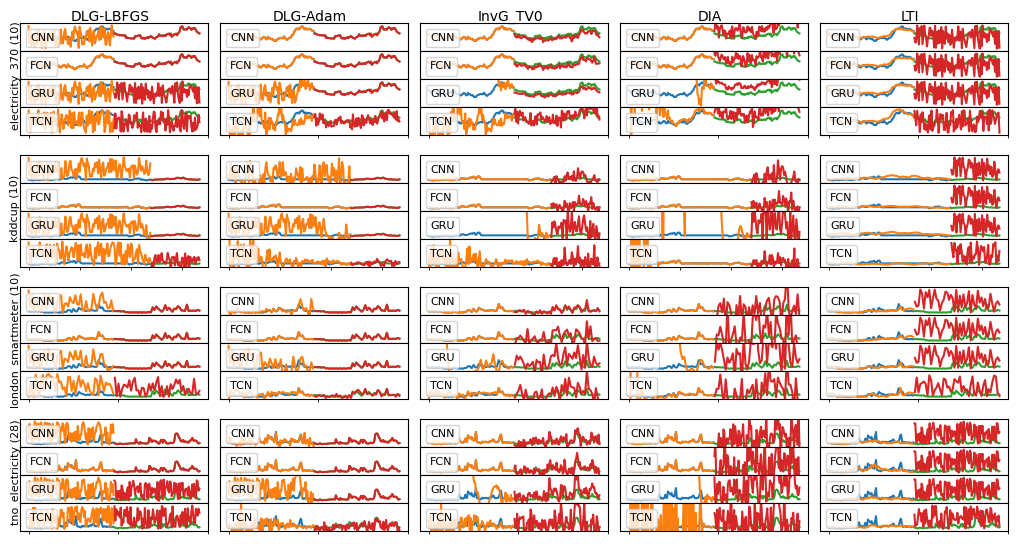

In [ ]:
# api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-baselines-time-series")
print(f'Found {len(runs)} runs')
filters = [
    {
        'experiment_name': lambda x: x == 'baselines_final_18-4-2024',
        'attack_method': lambda x: x != 'DIA'
    },
    {
        'experiment_name': lambda x: x == 'baselines_final_dia_lr_schedular_fix_23-4-2024',
        'attack_method': lambda x: x == 'DIA'
    }
]

attack_methods_ordered_list = ['DLG-LBFGS', 'DLG-Adam', 'InvG_TV0', 'DIA', 'LTI']

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 28,
}

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='attack_method', rows='dataset', variables='model', filters=filters, runs=runs)
plot_reconstructions_in_grid(reconstruction_dict, attack_methods_ordered_list, u_rows, u_variables, dataset_seed_dict, extra_title='baselines_attack_method_x_model_x_dataset')

# Plot reconstructions for a specific seed & dataset

Found 3496 runs
dict_keys([('DIA', 'GRU'), ('DIA', 'TCN'), ('DIA', 'FCN'), ('DIA', 'CNN'), ('InvG_TV0', 'GRU'), ('InvG_TV0', 'TCN'), ('InvG_TV0', 'FCN'), ('InvG_TV0', 'CNN'), ('DLG-Adam', 'GRU'), ('DLG-Adam', 'TCN'), ('DLG-Adam', 'FCN'), ('DLG-Adam', 'CNN'), ('LTI', 'TCN'), ('LTI', 'CNN'), ('DLG-LBFGS', 'GRU'), ('LTI', 'GRU'), ('LTI', 'FCN'), ('DLG-LBFGS', 'TCN'), ('DLG-LBFGS', 'FCN'), ('DLG-LBFGS', 'CNN'), ('TS-Inverse', 'GRU'), ('TS-Inverse', 'TCN'), ('TS-Inverse', 'FCN'), ('TS-Inverse', 'CNN')])


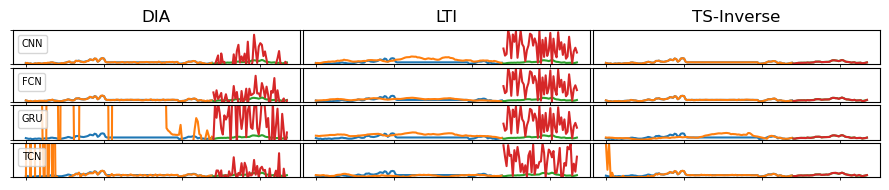

In [ ]:
import wandb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import torch
import dotenv
import json
import os

def gather_run_reconstructions_for_dataset(seed, dataset, columns, rows, filters, runs):
    # unique_columns, unique_rows = set(), set()
    def dataframe_keys_and_should_skip_run(run):
        if run.config['seed'] != seed or run.config['dataset'] != dataset:
            return [], True

        dataframe_keys = []
        for key in run.summary.keys():
            if 'dataframe' in key:
                dataframe_keys.append(key)
        if len(dataframe_keys) == 0:
            return [], True

        continue_next_run = [False for _ in range(len(filters))]
        for i, filter_dict in enumerate(filters):
            if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
                continue_next_run[i] = True
        if np.array(continue_next_run).all():
            return [], True
        return dataframe_keys, False

    def replace_predictor_name(runs_config, name):
        run_config_value = runs_config[name]
        if isinstance(run_config_value, str):
            return run_config_value.replace('JitGRU_Predictor', 'GRU_Predictor').replace('_Predictor', '')

        return run_config_value


    reconstructed_data_dict = {}
    if isinstance(runs, list):
        runs = [run for run_list in runs for run in run_list]
    for run in runs:
        dataframe_keys, should_skip_run = dataframe_keys_and_should_skip_run(run)
        if should_skip_run:
            continue

        run_column = replace_predictor_name(run.config, columns)
        run_row = replace_predictor_name(run.config, rows)

        dataframe_info = run.summary[dataframe_keys[0]]
        file = run.file(dataframe_info['path'])
        if not os.path.exists(file.name):
            file.download(replace=True)
        with open(file.name, 'r') as f:
            data = json.load(f)    
        reconstructed_data = pd.DataFrame(data=data['data'], columns=data['columns'])

        if (run_column, run_row) not in reconstructed_data_dict:
            reconstructed_data_dict[(run_column, run_row)] = reconstructed_data

    print(reconstructed_data_dict.keys())

    unique_columns = sorted(list(set([column for column, _ in reconstructed_data_dict.keys()])))
    unique_rows = sorted(list(set([row for _, row in reconstructed_data_dict.keys()])))

    return reconstructed_data_dict, unique_columns, unique_rows

def plot_reconstructions_in_grid_for_dataset(series_dict, unique_columns, unique_rows, seed='', dataset=''):
    plot_size_width, plot_size_height = 3, 0.5
    fig, axes = plt.subplots(len(unique_rows), len(unique_columns), figsize=(plot_size_width*len(unique_columns), plot_size_height*len(unique_rows)), sharex=True, sharey=True)
    for i, row_label in enumerate(unique_rows):
        for j, column_label in enumerate(unique_columns):
            reconstructed_data = series_dict[(column_label, row_label)]
            reconstructed_data.plot(ax=axes[i, j], legend=False)
            if j == 0:
                dummy_handle = mlines.Line2D([], [], color='none', label=row_label)
                axes[i, j].legend(handles=[dummy_handle], loc='upper left', handlelength=0, handletextpad=0, fancybox=True, fontsize='7')
            if i == 0:
                axes[i, j].set_title(column_label)
            axes[i, j].set_ylim(0, 1)
            axes[i, j].set_yticks([])
            axes[i, j].set_xticks([])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Adjust these values as needed
    fig.savefig(f'./out/plots/reconstructions/grid_single_seed_{dataset}_{seed}.pdf')
    plt.show()


dotenv.load_dotenv()

api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-baselines-time-series")
runs_ts_inverse = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs) + len(runs_ts_inverse)} runs')
# filters = [
#     {
#         'experiment_name': lambda x: x == 'baseline_ablation_experiments-28-3-2024',
#         'attack_method': lambda x: x != 'DLG-Adam-MAE-Clamp2' and x != 'InvG_TV0'
#     },
#     {
#         'experiment_name': lambda x: x == 'lti_ablation_experiments-28-3-2024',
#     }, 
#     {
#         'experiment_name': lambda x: x == 'fixed_cosine_signed_experiments-12-4-2024'
#     },
#     {
#         'experiment_name': lambda x: x == 'ts-inverse_final_experiments-17-4-2024',
#     }
# ]
filters = [
    {
        'experiment_name': lambda x: x == 'baselines_final_18-4-2024',
    },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_18-4-2024',
    }
]

# attack_methods_ordered_list = ['DLG-LBFGS', 'DLG-Adam', 'InvG_TV0', 'DIA', 'LTI', 'TS-Inverse']
attack_methods_ordered_list = ['DIA', 'LTI', 'TS-Inverse']

# series_dict, u_columns, u_rows = gather_run_reconstructions_for_dataset(seed=43, dataset='electricity_370', columns='attack_method', rows='model', filters=filters, runs=runs)
# plot_reconstructions_in_grid_for_dataset(series_dict, attack_methods_ordered_list, u_rows, seed=10, dataset='electricity_370')

# series_dict, u_columns, u_rows = gather_run_reconstructions_for_dataset(seed=28, dataset='tno_electricity', columns='attack_method', rows='model', filters=filters, runs=runs)
# plot_reconstructions_in_grid_for_dataset(series_dict, attack_methods_ordered_list, u_rows, seed=28, dataset='tno_electricity')

# series_dict, u_columns, u_rows = gather_run_reconstructions_for_dataset(seed=10, dataset='london_smartmeter', columns='attack_method', rows='model', filters=filters, runs=runs)
# plot_reconstructions_in_grid_for_dataset(series_dict, attack_methods_ordered_list, u_rows, seed=10, dataset='london_smartmeter')

series_dict, u_columns, u_rows = gather_run_reconstructions_for_dataset(seed=10, dataset='kddcup', columns='attack_method', rows='model', filters=filters, runs=runs)
plot_reconstructions_in_grid_for_dataset(series_dict, attack_methods_ordered_list, u_rows, seed=10, dataset='kddcup')

# Reconstructions old DLG implementation for different batch sizes, model.eval() was enabled so results are better for TCN

In [ ]:
# import wandb
# import matplotlib.pyplot as plt
# import matplotlib.lines as mlines
# import numpy as np
# import pandas as pd
# import torch
# import dotenv
# import json
# import os

# dotenv.load_dotenv()

# PROJECT_NAME = "capsar-meijer/tno-fl-dlg-time-series"

# api = wandb.Api()
# runs = api.runs(PROJECT_NAME)
# print(f'Found {len(runs)} runs')
# filters = [
#     {
#         'experiment_name': lambda x: x == 'dlg_experiment-13-3-2024',
#         'batch_size': lambda x: x == 1,
#         'hidden_size': lambda x: x == 64,
#     }
# ]

# def gather_run_reconstructions_of_attack_method(seed, columns, rows, filters, runs):
#     unique_columns, unique_rows = set(), set()
#     for run in runs:
#         if run.config['seed'] != seed:
#             continue

#         dataframe_keys = []
#         for key in run.summary.keys():
#             if 'dataframe' in key:
#                 dataframe_keys.append(key)
#         if len(dataframe_keys) == 0:
#             continue

#         continue_next_run = [False for _ in range(len(filters))]
#         for i, filter_dict in enumerate(filters):
#             if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
#                 continue_next_run[i] = True
#         if np.array(continue_next_run).all():
#             continue

#         column_label = run.config[columns].replace('JitGRU_Predictor', 'GRU_Predictor')
#         row_label = run.config[rows].replace('JitGRU_Predictor', 'GRU_Predictor')

#         unique_columns.add(column_label)
#         unique_rows.add(row_label)

#     unique_columns = sorted(list(unique_columns))
#     unique_rows = sorted(list(unique_rows))
#     print(unique_columns, unique_rows)

#     reconstructed_data_dict = {}

#     for run in runs:
#         if run.config['seed'] != seed:
#             continue

#         dataframe_keys = []
#         for key in run.summary.keys():
#             if 'dataframe' in key:
#                 dataframe_keys.append(key)
#         if len(dataframe_keys) == 0:
#             continue

#         continue_next_run = [False for _ in range(len(filters))]
#         for i, filter_dict in enumerate(filters):
#             if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
#                 continue_next_run[i] = True
#         if np.array(continue_next_run).all():
#             continue

#         column_label = run.config[columns].replace('JitGRU_Predictor', 'GRU_Predictor')
#         row_label = run.config[rows].replace('JitGRU_Predictor', 'GRU_Predictor')

#         j = unique_columns.index(column_label)
#         i = unique_rows.index(row_label)

#         dataframe_info = run.summary[dataframe_keys[0]]
#         file = run.file(dataframe_info['path'])
#         if not os.path.exists(file.name):
#             file.download(replace=True)
#         with open(file.name, 'r') as f:
#             data = json.load(f)    
#         reconstructed_data = pd.DataFrame(data=data['data'], columns=data['columns'])

#         if (i, j) not in reconstructed_data_dict:
#             reconstructed_data_dict[(i, j)] = reconstructed_data

#     title = f'DLG & seed: {seed}'

#     return unique_columns, unique_rows, reconstructed_data_dict, title

# def plot_reconstructions_in_grid(unique_columns, unique_rows, series_dict, title):
#     plot_size_width, plot_size_height, batch_size = 5, 1, 1

#     fig = plt.figure(constrained_layout=True, figsize=(plot_size_width*len(unique_columns), plot_size_height*len(unique_rows)*batch_size))
#     subfigs = fig.subfigures(len(unique_rows), len(unique_columns))

#     for (i, j), reconstructed_data in series_dict.items():
#         row_label, column_label = unique_rows[i], unique_columns[j]
#         n_batches = len(reconstructed_data.columns) // 4
#         axes_1 = subfigs[i, j].subplots(n_batches, 1, sharex=True, sharey=True)
#         if n_batches == 1: axes_1 = [axes_1]
#         for i in range(n_batches):
#             df_plot = reconstructed_data[[f'batch_inputs_{i}_0', f'dummy_inputs_{i}_0', f'batch_targets_{i}', f'dummy_targets_{i}']]
#             df_plot.plot(ax=axes_1[i], legend=False)

#         if j == 0:
#             print(row_label)
#             subfigs[i, j].suptitle(row_label)

#         # if j == 0 and i == 0:
#         #     subfigs[i, j].suptitle(f'{row_label} & {column_label}')
#         # else: 
#             # if i == 0:
#             #     subfigs[i, j].suptitle(column_label)
#         # axes[i, j].set_ylim(0, 1)
#     # plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Adjust these values as needed
#     plt.suptitle(title)
#     plt.show()

# u_columns, u_rows, series_dict, title = gather_run_reconstructions_of_attack_method(seed=28, columns='dataset', rows='model', filters=filters, runs=runs)
# plot_reconstructions_in_grid(u_columns, u_rows, series_dict, title)

# DROPOUT Effect on TCN reconstruction attacks

In [ ]:
import wandb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import torch
import dotenv
import json
import os

dotenv.load_dotenv()

PROJECT_NAME = "capsar-meijer/tno-fl-baselines-time-series"

api = wandb.Api()
runs = api.runs(PROJECT_NAME)
print(f'Found {len(runs)} runs')

dataset_seed_dict = {
    'electricity_370': 43,
    'kddcup': 43,
    'london_smartmeter': 10,
    'tno_electricity': 28,
}

filters = [
    {
        'experiment_name': lambda x: x == 'baseline_ablation_experiments-28-3-2024',
        'attack_method': lambda x: x != 'DLG-Adam-MAE-Clamp2' and x != 'InvG_TV0'
    },
    {
        'experiment_name': lambda x: x == 'lti_ablation_experiments-28-3-2024',
    }, 
    {
        'experiment_name': lambda x: x == 'fixed_cosine_signed_experiments-12-4-2024'
    }
]
attack_methods_ordered_list = ['DLG-LBFGS', 'DLG-Adam', 'InvG_TV0', 'DIA', 'LTI']

# reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='attack_method', variables='model', filters=filters, runs=runs)
# plot_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables)

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='attack_method', rows='dataset', variables='dropout', filters=filters, runs=runs)
plot_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, dataset_seed_dict, title='dropout')

# reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='model', variables='attack_method', filters=filters, runs=runs)
# plot_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables)

# Total Variation for InvG Reconstructions

In [ ]:
import wandb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import torch
import dotenv
import json
import os

def gather_run_reconstructions_for_dataset(seed, dataset, columns, rows, filters, runs):
    # unique_columns, unique_rows = set(), set()
    def dataframe_keys_and_should_skip_run(run):
        if run.config['seed'] != seed or run.config['dataset'] != dataset:
            return [], True

        dataframe_keys = []
        for key in run.summary.keys():
            if 'dataframe' in key:
                dataframe_keys.append(key)
        if len(dataframe_keys) == 0:
            return [], True

        continue_next_run = [False for _ in range(len(filters))]
        for i, filter_dict in enumerate(filters):
            if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
                continue_next_run[i] = True
        if np.array(continue_next_run).all():
            return [], True
        return dataframe_keys, False

    def replace_predictor_name(runs_config, name):
        run_config_value = runs_config[name]
        if isinstance(run_config_value, str):
            return run_config_value.replace('JitGRU_Predictor', 'GRU_Predictor').replace('_Predictor', '')

        return run_config_value


    reconstructed_data_dict = {}
    for run in runs:
        dataframe_keys, should_skip_run = dataframe_keys_and_should_skip_run(run)
        if should_skip_run:
            continue

        run_column = replace_predictor_name(run.config, columns)
        run_row = replace_predictor_name(run.config, rows)

        dataframe_info = run.summary[dataframe_keys[0]]
        file = run.file(dataframe_info['path'])
        if not os.path.exists(file.name):
            file.download(replace=True)
        with open(file.name, 'r') as f:
            data = json.load(f)    
        reconstructed_data = pd.DataFrame(data=data['data'], columns=data['columns'])

        if (run_column, run_row) not in reconstructed_data_dict:
            reconstructed_data_dict[(run_column, run_row)] = reconstructed_data

    print(reconstructed_data_dict.keys())

    unique_columns = sorted(list(set([column for column, _ in reconstructed_data_dict.keys()])))
    unique_rows = sorted(list(set([row for _, row in reconstructed_data_dict.keys()])))

    return reconstructed_data_dict, unique_columns, unique_rows

def plot_reconstructions_in_grid_for_dataset(series_dict, unique_columns, unique_rows, seed='', dataset='', column=''):
    plot_size_width, plot_size_height = 4, 1
    fig, axes = plt.subplots(len(unique_rows), len(unique_columns), figsize=(plot_size_width*len(unique_columns), plot_size_height*len(unique_rows)), sharex=True, sharey=True)
    for i, row_label in enumerate(unique_rows):
        for j, column_label in enumerate(unique_columns):
            reconstructed_data = series_dict[(column_label, row_label)]
            reconstructed_data.plot(ax=axes[i, j], legend=False)
            if j == 0:
                dummy_handle = mlines.Line2D([], [], color='none', label=row_label)
                axes[i, j].legend(handles=[dummy_handle], loc='upper left', handlelength=0, handletextpad=0, fancybox=True, fontsize='7')
            if i == 0:
                axes[i, j].set_title(column_label)
            axes[i, j].set_ylim(0, 1)
            axes[i, j].set_yticks([])
            axes[i, j].set_xticks([])

    plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Adjust these values as needed
    fig.savefig(f'./out/plots/reconstructions/grid_single_seed_{dataset}_{seed}_{column}.pdf')
    plt.show()


dotenv.load_dotenv()

PROJECT_NAME = "capsar-meijer/tno-fl-baselines-time-series"

api = wandb.Api()
runs = api.runs(PROJECT_NAME)
print(f'Found {len(runs)} runs')
filters = [
    {
        'experiment_name': lambda x: x == 'invg_total_variation-15-4-2024'
    }
]


series_dict, u_columns, u_rows = gather_run_reconstructions_for_dataset(seed=28, dataset='tno_electricity', columns='total_variation_alpha', rows='model', filters=filters, runs=runs)
plot_reconstructions_in_grid_for_dataset(series_dict, u_columns, u_rows, seed=28, dataset='tno_electricity', column='total_variation_alpha')

series_dict, u_columns, u_rows = gather_run_reconstructions_for_dataset(seed=28, dataset='electricity_370', columns='total_variation_alpha', rows='model', filters=filters, runs=runs)
plot_reconstructions_in_grid_for_dataset(series_dict, u_columns, u_rows, seed=28, dataset='electricity_370', column='total_variation_alpha')

series_dict, u_columns, u_rows = gather_run_reconstructions_for_dataset(seed=28, dataset='london_smartmeter', columns='total_variation_alpha', rows='model', filters=filters, runs=runs)
plot_reconstructions_in_grid_for_dataset(series_dict, u_columns, u_rows, seed=28, dataset='london_smartmeter', column='total_variation_alpha')

series_dict, u_columns, u_rows = gather_run_reconstructions_for_dataset(seed=28, dataset='kddcup', columns='total_variation_alpha', rows='model', filters=filters, runs=runs)
plot_reconstructions_in_grid_for_dataset(series_dict, u_columns, u_rows, seed=28, dataset='kddcup', column='total_variation_alpha')

In [ ]:
from matplotlib.gridspec import GridSpec
from matplotlib.transforms import Bbox
import wandb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import torch
import dotenv
import json
import os

def gather_run_reconstructions(dataset_seed, columns, rows, variables, filters, runs):
    def dataframe_keys_and_should_skip_run(run):
        if run.config['seed'] != dataset_seed[run.config['dataset']]:
            return [], True

        dataframe_keys = []
        for key in run.summary.keys():
            if 'dataframe' in key:
                dataframe_keys.append(key)
        if len(dataframe_keys) == 0:
            return [], True

        continue_next_run = [False for _ in range(len(filters))]
        for i, filter_dict in enumerate(filters):
            if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
                continue_next_run[i] = True
        if np.array(continue_next_run).all():
            return [], True
        return dataframe_keys, False

    def replace_predictor_name(runs_config, name):
        run_config_value = runs_config[name]
        if isinstance(run_config_value, str):
            return run_config_value.replace('JitGRU_Predictor', 'GRU_Predictor').replace('_Predictor', '')

        return run_config_value

    reconstructed_data_dict = {}
    for run in runs:
        dataframe_keys, should_skip_run = dataframe_keys_and_should_skip_run(run)
        if should_skip_run:
            continue

        run_column = replace_predictor_name(run.config, columns)
        run_row = replace_predictor_name(run.config, rows)
        run_variable = replace_predictor_name(run.config, variables)

        dataframe_info = run.summary[dataframe_keys[0]]
        file = run.file(dataframe_info['path'])
        if not os.path.exists(file.name):
            file.download(replace=True)
        with open(file.name, 'r') as f:
            data = json.load(f)
        reconstructed_data = pd.DataFrame(data=data['data'], columns=data['columns'])
        if (run_column, run_row, run_variable) not in reconstructed_data_dict:
            reconstructed_data_dict[(run_column, run_row, run_variable)] = reconstructed_data

    print(reconstructed_data_dict.keys())

    unique_columns = sorted(list(set([column for column, _, _ in reconstructed_data_dict.keys()])))
    unique_rows = sorted(list(set([row for _, row, _ in reconstructed_data_dict.keys()])))
    unique_variables = sorted(list(set([variable for _, _, variable in reconstructed_data_dict.keys()])))

    return reconstructed_data_dict, unique_columns, unique_rows, unique_variables

def plot_reconstructions_in_grid(series_dict, unique_columns, unique_rows, unique_variables, dataset_seed_dictionary, extra_title=""):
    plot_size_width, plot_size_height = 5, 1
    fig = plt.figure(figsize=(plot_size_width*len(unique_columns), plot_size_height*len(unique_rows)*len(unique_variables)))
    subfigs = fig.subfigures(len(unique_rows), len(unique_columns)+1)

    for i, row_label in enumerate(unique_rows):
        for j, column_label in enumerate(unique_columns):
            subfig = subfigs[i, j]
            subfig.subplots_adjust(wspace=0, hspace=0, left=0.05, right=0.99, top=0.9, bottom=0.05)
            axes_1 = subfig.subplots(len(unique_variables), 1, sharex=True, sharey=True)
            if len(unique_variables) == 1:
                axes_1 = [axes_1]
            for k, variable in enumerate(unique_variables):
                reconstructed_data = series_dict[(column_label, row_label, variable)]
                reconstructed_data.plot(ax=axes_1[k], legend=False)
                # if j == 0 and k == 2:
                # axes_1[k].set_ylabel(f'{k}', rotation=0)

                axes_1[k].set_ylim(-0.1, 1.1)
                axes_1[k].set_yticks([])
                axes_1[k].set_xticks([])
                dummy_handle = mlines.Line2D([], [], color='none', label=variable)
                axes_1[k].legend(handles=[dummy_handle], loc='upper left', handlelength=0, handletextpad=0, fancybox=True, fontsize=8)

            # subfig.text(0.5, 1, f'{row_label} - {column_label}', ha='center', va='top')
            if i == 0:
                subfig.text(0.5, 1, column_label, ha='center', va='top')
            if j == 0:
                subfig.text(0.0, 0.5, f'{row_label} ({dataset_seed_dictionary[row_label]})', ha='left', va='center', fontsize=8, rotation=90)

    fig.savefig(f'./out/plots/reconstructions/grid_{extra_title}_dataset_model.pdf')
    plt.show()

dotenv.load_dotenv()

PROJECT_NAME = "capsar-meijer/tno-fl-ts-inverse"

api = wandb.Api()
runs = api.runs(PROJECT_NAME)
print(f'Found {len(runs)} runs')
filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_experiments-17-4-2024',
    }
]
attack_methods_ordered_list = ['TS-Inverse']


dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 43,
    'london_smartmeter': 10,
    'tno_electricity': 28,
}

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='attack_method', rows='dataset', variables='model', filters=filters, runs=runs)
plot_reconstructions_in_grid(reconstruction_dict, attack_methods_ordered_list, u_rows, u_variables, dataset_seed_dict, extra_title='attack_method')

In [ ]:
PROJECT_NAME = "capsar-meijer/tno-fl-baselines-time-series"
api = wandb.Api()
runs = api.runs(PROJECT_NAME)
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'dlg-baselines_experiments-20-3-2024',
        'attack_method': lambda x: x == 'InvG',
        'total_variation_alpha': lambda x: x == 0.0001 or x == 0
    },
    {
        'experiment_name': lambda x: x == 'dlg-baselines_experiments-20-3-2024',
        'attack_method': lambda x: x == 'DLG-LBFGS',
        'learning_rate': lambda x: x == 0.005
    },
    {
        'experiment_name': lambda x: x == 'dlg-baselines_experiments-20-3-2024',
        'attack_method': lambda x: x == 'DLG-Adam' or x == 'DLG-Adam-MAE-lr-decay' or x=='DLG-Adam-Clamp2' or \
            x=='DLG-Adam-lr-decay' or x=='DLG-Adam-lr-decay-Clamp2' or x=='DLG-Adam-MAE' or \
                x=='DLG-Adam-MAE-lr-decay-Clamp2' or x=='InvG-no-lr-decay' or x=='DLG-Adam-MAE-Clamp2',
    }, 
    {
        'experiment_name': lambda x: x == 'dia_ablation_experiments-10-4-2024'
    }
]
# filters = [
#     {
#         'experiment_name': lambda x: x == 'baseline_ablation_experiments-24-3-2024',
#     },
#     {
#         'experiment_name': lambda x: x == 'lti_ablation_experiments-27-3-2024',
#         'attack_init_weight': lambda x: x == False,
#         'grad_to_input_model': lambda x: x == 'GradToInputNN',
#         'attack_loss': lambda x: x == 'mse',
#         'learning_rate': lambda x: x == 1e-3,
#     }
# ]


# u_columns, u_rows, series_dictionary, title = gather_run_histories(columns='dataset', rows='model', lines='attack_method', filters=filters, runs=runs, y_axis=['inputs/smape/mean', 'targets/smape/mean'])
# plot_metrics_in_grid(u_columns, u_rows, series_dictionary, title, label_prefix='', x_limits=(0, 5000))
# plot_metrics(u_columns, u_rows, series_dictionary, title, label_prefix='', x_limits=(0, 5000))

# u_columns, u_rows, series_dictionary, title = gather_run_histories(columns='dataset', rows='model', lines='attack_method', filters=filters, runs=runs, y_axis=['inputs/smape/mean'])
# plot_metrics_in_grid(u_columns, u_rows, series_dictionary, title, label_prefix='', x_limits=(0, 5000))
# plot_metrics(u_columns, u_rows, series_dictionary, title, label_prefix='', x_limits=(0, 5000))

# u_columns, u_rows, series_dictionary, title = gather_run_histories(columns='dataset', rows='model', lines='attack_method', filters=filters, runs=runs, y_axis=['targets/smape/mean'])
# plot_metrics_in_grid(u_columns, u_rows, series_dictionary, title, label_prefix='', x_limits=(0, 5000))
# plot_metrics(u_columns, u_rows, series_dictionary, title, label_prefix='', x_limits=(0, 5000))